# Reinforcement Learning

1. RL Intro
2. Dynamic Programing
3. Tabular Q-Learning
4. **Deep Reinforcement Learning (DQN)**

## 4. Deep Reinforcement Learning (DQN)

Welcome to the final Reinforcement Notebook. In this part we will implement the Deep Q-Learning Algorithm that was used by Mnih et al. to play Atari Video games. The resulting agent is called Deep Q-Network agent (or shorter DQN agent) because it uses a Deep Neural Network to approximate the value function (instead of saving it in a table).

---

## Theory

In the last notebook we have implemented the model-free **Q-Learning** algorithm and solved the *full reinforcement learning problem* by **learning from samples**. In this context, *full* refered to the fact that we dont have acess to the world model and *model-free* to the fact that we have not tried to learn that model. Furthermore, Q-Learning performed **online** updates to the policy, meaning that we have adjusted the policy *online* after every time step. Finally Q-Learning is an **off-policy** algorithm because we followed an e-greedy behavior policy while we have performed updates according to a greedy target policy. Now we will tackle the **curse of dimensionality** by **approximating the value function** instead of saving it explicitly in a table.

### Case Study - Video Games

<img src="./Atari_games.png" alt="DQN" style="width: 1000px;"/>

Before we proceed to the solution, let us quickly revise the actual problem that we are trying to solve. Consider the task of learning to play a video game given only the raw game screen as input. This is similar to how humans would play the game. Since the game screen is typically represented as raw pixels, this leaves us with a really high dimensional input or state space because every change of pixels represents a new and distinct state of the game, even if the change seems completely insignificant to you! Remember, the agent has no real knowledge of the game (or world model). Clearly it is infeasible to store every possible state of pixle combinations in a table. See [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) chapter 16.5 for a comprehensive discussion.   

<img src="./DQN_principle.png" alt="DQN" style="width: 800px;"/>

> The problem that is solved by Deep Reinforcement Learning (in the case of DQN) is how to learn a mapping from a high dimensional input space to action values. This mapping represents the value function and can be used in a policy, e.g. to choose the best action with the highest value.


### Nonlinear Function Approximation with Artificial Neural Networks

First of all, a lookup table can mathematically be seen as a very simple form of a function, i.e. a direct mapping of values (hence the name value function). However, for the reasons explained above, this approach does not scale to high dimensional input spaces. A typical solution to this problem is to replace the *perfect* but intractable lookup table with a more complicated function that *only* **approximates the true value function** but is computationally tractable. In the case of DQN we choose a deep neural network as our function approximator. Formally, this new function is denoted as $\hat{Q}$ and we write

$$\begin{eqnarray} 
\hat{Q}(s,a,\theta) \approx Q_{\pi}(s,a)
\end{eqnarray}$$

where $\theta$ are the parameters of the neural network. In other words, the value function now depends on those parameters and the task of finding and optimal value function turns into the task of finding an optimal set of parameters for the network. Fortunately, we know how to train and optimize a neural network with SGD and backpropagation given an appropriate loss function. **Inside the RL-framework we can use the TD-error as the loss function**. Formally we optimize:  

$$\begin{eqnarray} 
L_i(\theta_{i}) = \Big( \underbrace{r_{t+1} + \gamma \max_a Q(s_{t+1}, a; \theta_i) - Q(s_t, a_t;\theta_i)}_{TD-error} \Big)^2
\end{eqnarray}$$

> Note that in order to obtain any action-values, we now need to perform a forward pass through the network. In practice, this means two forward passes before we can calculate the loss, one pass for the value of $Q(s_t, a_t;\theta_i)$ and another one to calculate the value of $\max_a Q(s_{t+1}, a; \theta_i)$. More details on that later.


### Instabilities and Solutions

So far, so good. By using the TD-error as loss function we can train the network in a supervised learning like setup. Sadly it is not that easy. Remember that in supervised learning we assumed the data to be *independent and identically distributed* (iid-data) in order for SGD to work properly. This assuption does not hold in reinforcement learning where subsequent data is highly correlated and in contrast, depends strongly on the agents last choice of actions. This inherent sequential property, in combination with an off-policy algorithm and a non-linear function appoximator such as a neural network, results in the problem that the learnable network parameters are at risk to oscillate or even diverge catastrophically during training. In theory, there is no convergence guarantee whatsoever. In practice, Mnih et al. found two major ways in which the training process can be stabilized:

- **Experience Replay** - This idea introduces a so called **replay buffer** $\mathcal{D}$ which stores the last $N$ state transitions as experience tuples $(S,A,R,S')$. In other words, the agent saves its recent history to a buffer. This way, experience can be reused and the correlation between samples can be broken by **drawing random minibatches** of experience $U(\mathcal{D})$ from it during the training.
<br><br>

- **Fixed Q-Targets** - The second idea is to keep **a separate set of parameters** $\theta^{−}$ for calculating the **TD target**. This set is basically a copy of $\theta$ that is held fixed for some time $t$ and periodically gets swapped with the current parameter values in order to allow progress. Mnih et al. have shown that updating $\theta$ towards such fixed Q-targets is another effective way to stabilize the training process. In practice, this means that we have basically two separate networks which we will distinguish by their different set of parameters $\theta^{-}$ and $\theta$. We will refer to them respectively as **Target-** and **Q-Network**.

As a result, the **Q-learning update** of DQN at iteration $i$ uses the following loss function: 

$$\begin{eqnarray} 
L_i(\theta_{i}) = \mathbb{E}_{(s,a,r,s') \sim U(\mathcal{D})} \Bigg[ \Bigg( r_{t+1} + \gamma \max_a \underbrace{Q(s_{t+1}, a; \theta^{-}_{i})}_{Target-Network} - \underbrace{Q(s_t, a_t;\theta_i)}_{Q-Network} \Big)^2 \Bigg]
\end{eqnarray}$$

And thats it! We can use this update rule inside the Q-Learning algorithm to train a Deep Q-Network with SGD as we do in supervised learning. The corresponding **Deep Q-Learning algorithm** is given in the next part.

---

## Implementation

As in the previous notebooks we will implement the DQN algorithm step by step. While the original DQN architecture was a CNN trained on Atari games, we will choose a much simpler problem and architecture. This way you can verify and debug your implementation much faster (in minutes vs hours...). However, the algorithm itself is still the same and extending it should be straightforward.

The following is an overview of all the parts we need. We use it as a checklist. Like with Q-Learning, we try first to verify that all the sub-parts are working as expected.

##### Overview

- The OpenAI Gym Environment
- Replay Buffer
- Epsilon Schedule
- Deep Q-Network (and computation graph)
- E-Greedy Policy (action selection)
- Update the Target Network
- Train Method
- Main Loop
<br><br>
- Evaluation of Deep Reinforcement Learning Algorithms



### The Open AI Gym Environment

We will use the OpenAI Gym environment to solve a classic control task known as **Cart Pole Balance**. The great thing about the gym environment is that it offers a common interface to [many different environments](https://gym.openai.com/envs/#classic_control). That way you can easily test your algorithms on different tasks, e.g. switch from an easy one like CartPole to more challenging ones like an Atari game etc. ;)

For now, we will solve the **CartPole-v0** task. 

1. First of all, [we go and read](https://github.com/openai/gym/wiki/CartPole-v0) about its most important details such as the *observations, actions, rewards,* it's *max length* etc.
2. Second, we get used to the gym interface. We Run a random agent for some episodes etc. The most important API calls are:
    - `gym.make('CartPole-v0')` returns a new `game`.
    - The game's `action_space` and `observation_space` variables.
    - `reset()` - returns an initial `observation`.
    - `step()`  - takes an `action` int, returns an `observation, reward, game_over, info` tuple.
    - `render()` - renders the current game state.
    - `close()` - call this after the last episode has ended to clean up.

In [21]:
import gym
import random
import numpy as np
#define a random agent for the game
def random_agent(episodes, steps):
    
    #make a new game
    env = gym.make('CartPole-v0')
    
    for episode in range(episodes):
        #for every episode reset the game
        observation = env.reset()
        for i in range(steps):
            #env.render()
            #get a random action from both possible actions
            action = env.action_space.sample()
            #do action and get new state, reward, game over info and info
            observation, reward, game_over, info = env.step(action)
            print(observation, reward, game_over, info)
            #check if game over
            if game_over:
                print('Episode finished after {} steps'.format(i))
                break
    env.close()

random_agent(20, 100)

[ 0.02577703 -0.15628974  0.00464515  0.29117978] 1.0 False {}
[ 0.02265124 -0.35147762  0.01046875  0.58532411] 1.0 False {}
[ 0.01562169 -0.54674463  0.02217523  0.88128633] 1.0 False {}
[ 0.00468679 -0.74216067  0.03980096  1.18085731] 1.0 False {}
[-0.01015642 -0.93777603  0.0634181   1.48574636] 1.0 False {}
[-0.02891194 -1.13361102  0.09313303  1.79754075] 1.0 False {}
[-0.05158416 -0.9396466   0.12908385  1.53519656] 1.0 False {}
[-0.07037709 -1.13606517  0.15978778  1.86521853] 1.0 False {}
[-0.0930984  -1.33253593  0.19709215  2.20294838] 1.0 False {}
[-0.11974912 -1.13978162  0.24115111  1.97698514] 1.0 True {}
Episode finished after 9 steps
[ 0.00478715 -0.23503177 -0.01853886  0.25410996] 1.0 False {}
[ 8.65147100e-05 -4.29884171e-01 -1.34566641e-02  5.40888233e-01] 1.0 False {}
[-0.00851117 -0.62481442 -0.0026389   0.82930099] 1.0 False {}
[-0.02100746 -0.42965649  0.01394712  0.53578928] 1.0 False {}
[-0.02960059 -0.2347334   0.02466291  0.24753341] 1.0 False {}
[-0.03429

[ 0.02188817  0.19280135 -0.0263784  -0.29133152] 1.0 False {}
[ 0.0257442  -0.00193474 -0.03220503 -0.00708335] 1.0 False {}
[ 0.02570551  0.19363392 -0.0323467  -0.30975087] 1.0 False {}
[ 0.02957818 -0.00101259 -0.03854172 -0.02744211] 1.0 False {}
[ 0.02955793  0.19464028 -0.03909056 -0.33203192] 1.0 False {}
[ 3.34507387e-02  9.59095917e-05 -4.57311970e-02 -5.19279930e-02] 1.0 False {}
[ 0.03345266 -0.19434149 -0.04676976  0.2259829 ] 1.0 False {}
[ 0.02956583 -0.38876491 -0.0422501   0.50355382] 1.0 False {}
[ 0.02179053 -0.58326671 -0.03217902  0.78262833] 1.0 False {}
[ 0.01012519 -0.38771762 -0.01652646  0.47999755] 1.0 False {}
[ 0.00237084 -0.19236632 -0.0069265   0.18215205] 1.0 False {}
[-0.00147648 -0.38738847 -0.00328346  0.4726419 ] 1.0 False {}
[-0.00922425 -0.5824639   0.00616937  0.76428812] 1.0 False {}
[-0.02087353 -0.38742745  0.02145514  0.4735528 ] 1.0 False {}
[-0.02862208 -0.19261497  0.03092619  0.18770866] 1.0 False {}
[-0.03247438 -0.38816542  0.03468037  0

[-0.05637602 -0.21555522  0.02190184  0.32533163] 1.0 False {}
[-0.06068713 -0.41098205  0.02840848  0.6248402 ] 1.0 False {}
[-0.06890677 -0.21626798  0.04090528  0.34123791] 1.0 False {}
[-0.07323213 -0.02175117  0.04773004  0.06172956] 1.0 False {}
[-0.07366715  0.1726551   0.04896463 -0.21552043] 1.0 False {}
[-0.07021405 -0.02313142  0.04465422  0.09219721] 1.0 False {}
[-0.07067668 -0.21886402  0.04649817  0.39862742] 1.0 False {}
[-0.07505396 -0.02443149  0.05447071  0.12095939] 1.0 False {}
[-0.07554259 -0.22028983  0.0568899   0.43031764] 1.0 False {}
[-0.07994838 -0.02601769  0.06549626  0.15609747] 1.0 False {}
[-0.08046874  0.16810835  0.0686182  -0.1152251 ] 1.0 False {}
[-0.07710657  0.36218343  0.0663137  -0.38549472] 1.0 False {}
[-0.0698629   0.16618581  0.05860381 -0.07266254] 1.0 False {}
[-0.06653918  0.36042076  0.05715056 -0.34629514] 1.0 False {}
[-0.05933077  0.16453442  0.05022465 -0.03615223] 1.0 False {}
[-0.05604008  0.35890151  0.04950161 -0.31257537] 1.0 F

[ 0.00525523  0.39063514 -0.04134467 -0.63391792] 1.0 False {}
[ 0.01306793  0.58630869 -0.05402302 -0.93932929] 1.0 False {}
[ 0.02479411  0.39195499 -0.07280961 -0.66409909] 1.0 False {}
[ 0.03263321  0.19791738 -0.08609159 -0.39520093] 1.0 False {}
[ 0.03659155  0.39414866 -0.09399561 -0.71373738] 1.0 False {}
[ 0.04447453  0.59043755 -0.10827036 -1.03446503] 1.0 False {}
[ 0.05628328  0.78681955 -0.12895966 -1.35908248] 1.0 False {}
[ 0.07201967  0.59352879 -0.15614131 -1.10936304] 1.0 False {}
[ 0.08389025  0.79031889 -0.17832857 -1.44667642] 1.0 False {}
[ 0.09969662  0.59778165 -0.2072621  -1.21460174] 1.0 False {}
[ 0.11165226  0.40584628 -0.23155413 -0.9933601 ] 1.0 True {}
Episode finished after 13 steps
[ 0.02061312 -0.1478299   0.02147444  0.3210386 ] 1.0 False {}
[ 0.01765652 -0.34325098  0.02789521  0.62041563] 1.0 False {}
[ 0.0107915  -0.53875118  0.04030352  0.92175197] 1.0 False {}
[ 1.64778375e-05 -7.34393879e-01  5.87385614e-02  1.22682373e+00] 1.0 False {}
[-0.0146

### Replay Buffer

The replay buffer should store the last $N$ experience tuples. This is basically a FIFO queue and practically, [python offers such a data structure called](https://docs.python.org/3/library/collections.html#collections.deque) `deque`. If initialized with a `maxlen` parameter, `deque`'s `append` method will pop items from the left automatically when the list grows beyond the given `maxlen`. This is exactly what we want and **you can implement it in just a few lines of code!** The replay buffer should have the following methods:

- `__init__` constructor, initializing an internal `deque` with a given `maxlen` or $N$ or better, we call it `buffer_size`.
- `add` method, appending a new `[state, action, reward, next_state, done]` tuple. (`done` is the `game_over` information) 
- `sample` method, sample a random batch of training data of size `batch_size`. You can use `random`'s `sample` method for that.

We use the cells below to test our implementation, e.g. by filling it with some integers in a loop, check whats in the queue and test the sampling method etc.

In [22]:
import random as r
from collections import deque


class ReplayBuffer():
    def __init__(self, buffer_size):
        self.memory = deque(maxlen=buffer_size)
    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, float(done)))
    def sample(self, batch_size):
        return r.sample(self.memory,batch_size)

In [23]:
# TESTING the replay buffer
test_buffer = ReplayBuffer(2)
test_buffer.add(1,2,3,4,5)
test_buffer.add(6,7,8,9,10)
test_buffer.add(11,12,13,14,15)
test_buffer.add(16,17,18,19,20)
test_buffer.sample(2)

[(11, 12, 13, 14, 15.0), (16, 17, 18, 19, 20.0)]

### Epsilon Schedule

Last time, we calculated the current epsilon value inside the main loop. This time we need a little bit more control so let's create a class for that task. The reason for that is that we have to pre fill the replay buffer with some initial random experience before we can sample from it and start with the actual training. We want to control the amount of initial experience with a `pre_train_steps` variable. During this time, the schedule should return the `start_epsilon` value so that the agent behaves fully random. After that, the normal decay should be applied. The implementation needs two methods:

- `__init__` constructor, takes all hyper parameters for the schedule such as `start_epsilon, final_epsilon, pre_train_steps, final_exploration_step`, pre calculate the decay value per step here.
- `value` method, takes a time step `t` and returns a correpsonding `epsilon` value. If `t` is smaller or greater than the `pre_train_steps` or `final_exploration_step` return the fixed values accordingly. In between calculate the decayed `epsilon` value at time `t`.

We use the code in the cell below to test and visualize your schedule.

In [24]:
import numpy as np

class LinearSchedule():
 
    def __init__(self, start_epsilon, final_epsilon, pre_train_steps, final_exploration_step):
        self.start_epsilon = start_epsilon
        self.final_epsilon = final_epsilon
        self.pre_train_steps = pre_train_steps
        self.final_exploration_step = final_exploration_step
        #epsilon_decay is diffenrence of start and final epsilon divided by exploration steps
        self.epsilon_decay = (start_epsilon - final_epsilon) / (final_exploration_step - pre_train_steps)
        
    #get epsilon after t steps
    def value(self, t):
        if t < self.pre_train_steps:
            return self.start_epsilon
        elif t > self.final_exploration_step:
            return self.final_epsilon
        else:
            return self.start_epsilon - ((t-self.pre_train_steps)*self.epsilon_decay)

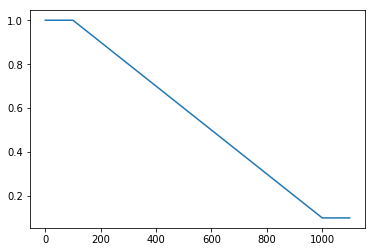

In [5]:
# TESTING the epsilon schedule
%matplotlib inline
import matplotlib.pyplot as plt
#test schedule for start_epsilon = 1, final_epsilon=0.1, pre_train_steps=100, final_exploration_step=1000
schedule    = LinearSchedule(1.0, 0.1, 100, 1000)
test_points = [schedule.value(t) for t in range(1100)]

plt.plot(test_points)

### Deep Q-Network

The original DQN agent included a CNN as shown in the theory part of this notebook. For our task however, a simple MLP with only one hidden layer should be enough. Starting that simple will help us to get other implementation details right. Later on we can easily scale up and switch the MLP for a more powerfull network.

While the architecture will be easy, the DQN algorithm requires us to keep basically two separate networks, namely, a main **Q-Network** and a second **Target-Network**. In addition, Tensorflow requires us to keep a reference to every node we want to calculate with the `sess.run` command. For those reasons we will build a *generic* and reusable `DQNetwork` class and bind all graph nodes to the object. Later we can then simply use the instance objects to reference specifc nodes in a clean and readable way.

We will implement the `DQNetwork` class below in two steps. The first part denoted as *basic Deep Q-Network*, includes the actual network. The second part denote as *Q-Learning Calculations*, includes all the additional calculations to train the network.

#### Part 1 - Basic Deep Q-Network

This part is identical for the main Q- and the Target-Network. **It includes all trainable variables of the graph!** The model should be a fully connected feedforward network with one hidden layer of size $64$ and **ReLU** activations. For the CartPole task, the resulting MLP will consequently be later of size `num_inputs=4, num_hidden=64, num_outputs=2`. For the generic `DQNetwork` class however, let the user specify those values as parameters.

- Now create a `self.best_action` node which should take the output layer (or q-values) and **return the indice** of the maximum action value. We can use `tf.argmax` for that. We can query this node in the e-greedy action selection later.

- Create another node, `self.max_q` which does the same thing but **returns the value** of the maximum action value. We can use `tf.reduce_max` for that. We will need this node for the calculation of the TD-target later.

So far, everything should have been very straightforward.

#### Part 2 - Q-Learning Calculations

This part is different for the Q- and the Target-Network. **It includes all the necessary calculations for training the network.** The code skeleton below shows how to constrain the graph creation with two simple if statements. 

First, the **Target Stream**. This part will later calculate the **TD-Target** (or $y_i$) with the following equation:

$$\begin{eqnarray} 
y_i = r_{t+1} + \gamma \max_a \underbrace{Q(s_{t+1}, a; \theta^{-}_{i})}_{Target-Network}
\end{eqnarray}$$

Remember that we will train with mini-batches sampled from the replay buffer. For that reason, the `reward` values will be provided by mini-batches. This means we have to feed them externally, so let's create a **placeholder node** for those. Next, gamma will be **a constant** so let's create one in tensorflow and let the user specify it as a parameter at creation time of the network. Next, $s_{t+1}$ are the `next_states` from the buffer. This is not important here but we have to feed them correctly later! To get the maximum action value, use the `self.max_q` node that we have created earlier. Finally, there is a small detail we have not talked about yet. **In the rare case that the next state is a final state, i.e the game is over, only the reward should be taken into account.** To realize this here is a little *trick*: create another placeholder for the boolean `done` values from the mini-batch. Then, multiply the right-hand side of the equation with `tf.abs(self.done - 1)`. For clarity call the final node which implements the equation above `self.td_target`! 

> Note that this is a *lot* of text but basically 4 lines of code!

Second, the **Q Stream**. This part will calculate the full **TD-Error** and optimize the mean squared error on the mini-batch.

$$\begin{eqnarray} 
L_i(\theta_{i}) = \mathbb{E}_{(s,a,r,s') \sim U(\mathcal{D})} \Bigg[ \Bigg( y_i - \underbrace{Q(s_t, a_t;\theta_i)}_{Q-Network} \Big)^2 \Bigg]
\end{eqnarray}$$

Now first, we create a placeholder for the **td-target** ($y_i$). These values have been calculated by the Target-Network and we must feed them again to the main Q-Network. Yes, its really two **separate** networks even though they share some code here. Next we need the value of $Q(s_t, a_t;\theta_i)$. We can query **all action values** by feeding the mini-batch of `states` ($s_t$) from the buffer to the network (first part of the network). The *problem* is that **we only want to select the action value of the action that was actually taken**. Luckily we have this information as part of the mini-batch. We can feed it with an additional placeholder, let's call it `self.actions`. The idea is now to mask the output of the network with a one-hot encoded representation of the action indices from the placeholder. To do this use `tf.one_hot` and call the resulting node `self.actions_onehot` or similar. Finally multiply the one_hot vector with the output of the network and call `tf.reduce_sum` on the result to obtain a clean list of the action values we want. The resulting node, let's call it `self.Q` holds the values of $Q(s_t, a_t;\theta_i)$ for the complete mini-batch.

> If you feel uncomfortable with this *trick* create a toy example in a separate cell in order to understand whats going on here.

Great, now the rest should be straightforward again. Square the difference of `td_target` and `Q` to obtain the **TD-error** and use `tf.reduce_mean` on that to obtain the expected **loss** of the mini-batch. This corresponds to $\mathbb{E}_{(s,a,r,s') \sim U(\mathcal{D})}$ in the formula. Create an optimizer node such as the AdamOptimizer and again, let the user specifiy the learnin rate as a parameter at creation time of the network. Finally minimize the loss and call this final node something like `self.updateModel` or `self.train`.

> Note that this is again a *lot* of text but *only* something like ~8 lines of code!

In [6]:
import tensorflow as tf
tf.reset_default_graph()
#build a generic and reusable DQNetwork class and bind all graph nodes to the object
class DQNetwork():
    
    def __init__(self, scope, num_inputs=4, num_hidden=64, num_outputs=2, gamma=0.9, learnrate=0.5):
        
        self.scope = scope
        
        with tf.variable_scope(self.scope, reuse=tf.AUTO_REUSE):

            self.scope = scope
            self.num_inputs = num_inputs
            self.num_hidden = num_hidden
            self.num_outputs = num_outputs
            self.gamma = gamma
            
            # ---------------------
            # Basic Deep Q-Network
            # ---------------------
            """
            This part is identical for the main Q- and the Target-Network. 
            It includes all trainable variables of the graph! 
            The model should be a fully connected feedforward network with one hidden layer of size 64 and ReLU activations. 
            For the CartPole task, the resulting MLP will consequently be later of size num_inputs=4, num_hidden=64, num_outputs=2.
            """
            """
            # Define variables
            self.states = tf.placeholder(shape=[None, num_inputs], dtype=tf.float32)
            # create a fully connected hidden layer
            fc1 = tf.layers.dense(inputs=self.states, units=num_hidden, activation=tf.nn.relu)
            self.logits = tf.layers.dense(inputs=fc1, units=num_outputs)
            """
            #placeholder for input:
            self.input_placeholder = tf.placeholder(tf.float32, shape=[None, num_inputs], name='input_placeholder')
            #wheigts for hiddenLayer and outputLayer
            self.BW1 = tf.get_variable("BW1",shape= (self.num_inputs, self.num_hidden), initializer=tf.glorot_normal_initializer)
            self.BB1 = tf.get_variable("BB1",shape=(self.num_hidden), initializer=tf.zeros_initializer)
            self.BW2 = tf.get_variable("BW2",shape= (self.num_hidden, self.num_outputs), initializer=tf.glorot_normal_initializer)
            self.BB2 = tf.get_variable("BB2",shape=(self.num_outputs), initializer=tf.zeros_initializer)
            #hiddenLayer
            self.denseB = tf.matmul(self.input_placeholder, self.BW1) + self.BB1
            self.denseB = tf.nn.relu(self.denseB)
            #outputLayer
            self.outB = tf.matmul( self.denseB, self.BW2) + self.BB2
            #self.outB = tf.nn.relu(self.outB)
            
            """
            Now create a self.best_action node which should take the output layer (or q-values) and return the indice 
            of the maximum action value. 
            We can use tf.argmax for that. We can query this node in the e-greedy action selection later.
            """
            #best_action index
            self.best_action = tf.argmax(self.outB,axis=1)
            """
            Create another node, self.max_q which does the same thing but returns the value of the maximum action value. 
            You can use tf.reduce_max for that. You will need this node for the calculation of the TD-target later.
            """
            #return the value of the maximum action value
            self.max_q = tf.reduce_max(self.outB, axis=1)
            
            # ------------------------
            # Q-Learning Calculations
            # ------------------------
            
            if scope == 'Target':
                """
                Remember that we will train with mini-batches sampled from the replay buffer. 
                For that reason, the reward values will be provided by mini-batches. 
                This means we have to feed them externally, so let's create a placeholder node for those. 
                """
                self.rewards = tf.placeholder(dtype=tf.float32, name = 'rewards')
                
                """
                Next, gamma will be a constant so let's create one in tensorflow and let the user specify it 
                as a parameter at creation time of the network. 
                """
                
                self.gamma = tf.constant(gamma)
                """
                In the rare case that the next state is a final state, i.e the game is over, only the reward should be taken into account. 
                To realize this here is a little trick: create another placeholder for the boolean done values from the mini-batch. 
                """
                self.done = tf.placeholder(dtype=tf.float32, name = 'done')
                
                """
                Next, 𝑠𝑡+1 are the next_states from the buffer. This is not important here but you have to feed them correctly later! 
                To get the maximum action value, use the self.max_q node that you have created earlier. 
                Then, multiply the right-hand side of the equation with tf.abs(self.done - 1). 
                For clarity call the final node which implements the equation above self.td_target! 
                """
                self.td_target = tf.add(self.rewards, tf.multiply(tf.multiply(self.gamma, self.max_q),\
                                                                  tf.abs(tf.subtract(self.done, 1))),name = 'td_target' )
                
            if scope == 'Q':
                #placeholder to feed td_target from target network.
                self.td_target_placeholder = tf.placeholder(dtype=tf.float32, name = 'td_target_placeholder')
                #placeholder to feed action value of the action that was actually taken
                self.actions_placeholder = tf.placeholder(dtype=tf.int32, name = 'actions_placeholder')
                # now mask the output of the network with a one-hot encoded representation of the action indices from the placeholder. 
                self.actions_onehot = tf.one_hot(self.actions_placeholder, depth=2)
                #Finally multiply the one_hot vector with the output of the network 
                # obtain a clean list of the action values we want.
                self.Q = tf.reduce_sum(tf.multiply(self.actions_onehot, self.outB), axis=1)
                #TD-error
                self.td_error = tf.square(tf.subtract(self.td_target_placeholder, self.Q))
                self.loss = tf.reduce_mean(self.td_error)
                
                self.optimizer = tf.train.AdamOptimizer(learnrate)
                self.train = self.optimizer.minimize(self.loss)


In [7]:
# A cell for testing
testTarget = DQNetwork("Target", 4, 64 , 2)
testTarget = DQNetwork("Q", 4, 64 , 2)

In [8]:
#check graph with tensorboard
#writer = tf.summary.FileWriter('.')
#writer.add_graph(tf.get_default_graph())
#writer.flush()

#tensorboard --logdir .

### E-Greedy Policy

As in the Q-Learning notebook, let us encapsulate the action selection into a separate method. This time however, selecting a greedy max action requires us to perform a forward pass through the Q-Network. The method per se remains as simple as in the Q-Learning case. In order to perform the forward pass of the network though, we have to hand over a reference to the current Tensorflow session object from the main loop etc.

Note that the `sess.run` call will most certainly return a list, containing a single action indice. Make sure to *unpack* it properly before returning it. We can test this in separate cell or in the main loop by using a **fixed epsilon value**.

In [9]:
import numpy as np

#choose action greedily depending on state wheigts and epsilon 
def choose_egreedy_action(session, graph, state, epsilon):
    #do random action with a probability corresponding to epsilon 
    if np.random.random() < epsilon:
        return np.random.randint(low=0, high=2) #between 0 and 1
    else:
        #run network to choose best_action and unpack the result
        action = sess.run(graph.best_action, feed_dict={graph.input_placeholder : state})[0]
        return action


### Update the Target Network

As explained in the theory part, the Target-Network will be fixed for some time $C$ while the main Q-Network gets update every training/update step. Every $C$ time steps however we want to *switch* the networks or better, update the Target-Network with the latest information from the Q-Network. This basically means that we want to copy over all weights from the Q-Network and assign them to the Target-Network. The Q-Network itself remains unchanged. We will control this freeze frequency later inside the main loop and execute the copy process only every $C$ time steps.

Assigning new values to variables in Tensorflow can be done with the `tf.assign` method. But, as everything in TensorFlow, these assign operations will be tensor nodes and **we have to create them before we start the session**. Since they don't belong to any of the networks let us do this in an extra method.

> Note that in (before) the main loop we will have to create both networks first and then hand them to the `get_update_target_ops` method to obtain the list of assign operations!

- get all trainable variables of a network with `tf.trainable_variables(scope=)`.
- better sort the lists using `sorted` and the `attrgetter` helper, e.g `Q_vars = sorted(Q_vars, key=attrgetter('name'))`.
- create an empty list for the assign expressions, let's call them something like `update_target_expr`.
- loop over the variable lists and create assign opertations, e.g. `t_var.assign(q_var)`. Append them to the expression list.
- a handy way for iterating over two lists is zip in a for loop. See the cell below for a little demo.
- return the list of assign operations. We can later simply call `sess.run(update_target_expr)` to run all of the assign operations.


Use the cells below to test our implementation with some toy networks!

In [10]:
# Zip demo
x = [1,2,3]
y = [4,5,6]

for x,y in zip(x,y):
    print(x,y)

1 4
2 5
3 6


In [11]:
from operator import attrgetter

def get_update_target_ops(Q_network, Target_network):

    # 1. get the trainable variables per network
    #get all trainable variables of a network with tf.trainable_variables(scope=).
    Q_trainable_vars = tf.trainable_variables(scope='Q')
    Target_trainable_vars = tf.trainable_variables(scope='Target')

    
    # 2. sort them with sorted(list, key=attrgetter())
    #better sort the lists using sorted and the attrgetter helper, e.g Q_vars = sorted(Q_vars, key=attrgetter('name')).
    Q_trainable_vars = sorted(Q_trainable_vars, key=attrgetter('name'))
    Target_trainable_vars = sorted(Target_trainable_vars, key=attrgetter('name'))
    #print("Q_trainable_vars", Q_trainable_vars)
    #print("Target_trainable_vars", Target_trainable_vars)

    
    # 3.create a new list with all assign ops
    #create an empty list for the assign expressions, let's call them something like update_target_expr
    update_target_expr = []
    #loop over the variable lists and create assign opertations, e.g. t_var.assign(q_var).
    #Append them to the expression list.
    for Q_trainable_var, Target_trainable_var in zip(Q_trainable_vars, Target_trainable_vars):
        update_target_expr.append(Target_trainable_var.assign(Q_trainable_var))
    return update_target_expr

In [12]:
# TESTING get_update_target_ops with some toy networks
tf.reset_default_graph()
Q = DQNetwork("Q", 1,2,1) 
Target = DQNetwork("Target", 1,2,1)

Q_vars = tf.trainable_variables(scope="Q")
Target_vars = tf.trainable_variables(scope="Target")
update_target_expr = get_update_target_ops(Q, Target)

print("List of created Assign operations"), print(update_target_expr)
print("\n Q Variables"), print(Q_vars)
print("\n Target Variables"), print(Target_vars)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())        

    print("\n Q Values"), print(sess.run(Q_vars))
    print("\n Target Values"), print(sess.run(Target_vars))
    
    sess.run(update_target_expr)

    print("\n Target Values AFTER network copy. Should now be identical to the values of Q")
    print(sess.run(Target_vars))  

List of created Assign operations
[<tf.Tensor 'Assign:0' shape=(2,) dtype=float32_ref>, <tf.Tensor 'Assign_1:0' shape=(1,) dtype=float32_ref>, <tf.Tensor 'Assign_2:0' shape=(1, 2) dtype=float32_ref>, <tf.Tensor 'Assign_3:0' shape=(2, 1) dtype=float32_ref>]

 Q Variables
[<tf.Variable 'Q/BW1:0' shape=(1, 2) dtype=float32_ref>, <tf.Variable 'Q/BB1:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'Q/BW2:0' shape=(2, 1) dtype=float32_ref>, <tf.Variable 'Q/BB2:0' shape=(1,) dtype=float32_ref>]

 Target Variables
[<tf.Variable 'Target/BW1:0' shape=(1, 2) dtype=float32_ref>, <tf.Variable 'Target/BB1:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'Target/BW2:0' shape=(2, 1) dtype=float32_ref>, <tf.Variable 'Target/BB2:0' shape=(1,) dtype=float32_ref>]

 Q Values
[array([[-0.31879127, -0.29016402]], dtype=float32), array([0., 0.], dtype=float32), array([[ 0.95279896],
       [-0.52052546]], dtype=float32), array([0.], dtype=float32)]

 Target Values
[array([[0.2528751 , 0.45456573]], dtype=float3

Notice how Target Values are equal to Q Values AFTER network copy

### Train Method

Finally let's create a method to run the actual network training. Doing this in an extra method is not necessary per se but un-clutters the main loop a lot. The implementation requires the following three steps:

1. Sample a mini-batch of experience from the replay buffer. In order to feed everything to the DQNetworks, the mixed batch must be reshaped into separate **list** batches (`[]`!) of `observations, actions, rewards, next_observations` and `done`. Make sure this true before creating corresponding feed_dicts! Depending on your replay buffer implementation you way find it handy to use `zip` again and apply the `list` operator with the `map` function, e.g. `map(list, zip(*batch))`. See the cell below for an UnZip demo.
2. Prepare an appropriate `feed_dict` and get the `td_target` values by running the Target-Network.
3. Prepare an appropriate `feed_dict` and run the `update_model` or `train` operation of the main Q-Network.

Now we can simply call `train` inside the main loop every time we want to train the Q-Network.

In [13]:
# UnZip demo *
mini_batch = [[1,2,3], [1,2,3], [1,2,3]]
    
for i in zip(*mini_batch):
    print(i)

(1, 1, 1)
(2, 2, 2)
(3, 3, 3)


In [14]:
#reminder: replaybuffer order : state, action, reward, next_state, done

def train(sess, Q, Target, buffer, batch_size):
    # 1. Sample from the replay buffer:
    #Sample a mini-batch of experience from the replay buffer. In order to feed everything to the DQNetworks, 
    #the mixed batch must be reshaped into separate list batches ([]!) of 
    #observations, actions, rewards, next_observations and done. 
    #Make sure this true before creating corresponding feed_dicts! 
    #Depending on your replay buffer implementation you way find it handy to use 
    #zip again and apply the list operator with the map function, e.g. map(list, zip(*batch)).
    #See the cell below for an UnZip demo.
    mini_batch = buffer.sample(batch_size)
    mini_batch = list(map(list, zip(*mini_batch)))
    #print(mini_batch[0])
    #print(mini_batch[1])
    #print(mini_batch[2])
    #print(mini_batch[3])
    #print(mini_batch[4])

    
    # 2. Retrieve the TD-target values from the Target-Network
    #Prepare an appropriate feed_dict and get the td_target values by running the Target-Network.
    # we feed next_state, reward and done
    td_target = sess.run(Target.td_target, feed_dict = {Target.input_placeholder: mini_batch[3], Target.rewards:mini_batch[2],\
                                  Target.done:mini_batch[4]})
    
    # 3. Perform a training step by running the main Q-Network
    # we feed action and state
    sess.run(Q.train, feed_dict = {Q.td_target_placeholder: td_target, Q.actions_placeholder: mini_batch[1],\
                                   Q.input_placeholder: mini_batch[0]})

### Main Loop

Below we can see the **Deep Q-Learning** pseudo code from the original paper. This will help us to get at least the main parts of the algorithm right and should serve as a rough blue print of when to do what inside the loop. In practice, there are many more subtle details which are not mentioned explicitly.


---
##### Deep Q-Learning with experience replay

- Initialize replay memory $D$ to capacity $N$
- Initialize action-value function $Q$ with random weights $\theta$
- Initialize target action-value function $\hat{Q}$ with random weights $\theta^{-}$

- **For** $t = 1, T$ **do**
    - With probability $\epsilon$ select a random action $a_t$
    - otherwise select $a_t = \text{arg}\max_a Q(s_t,a;\theta)$
    <br><br>
    - Execute action $a_t$ in emulator and observe reward $r_t$ and state $s_{t+1}$
    - Store transition $(s_t,a_t,r_t,s_{t+1})$ in $D$
    - Sample random minibatch transitions $(s_j,a_j,r_j,s_{j+1})$ from $D$
    - set    
    $
    y_j = \begin{cases}
          r_j  & \text{if episode terminates at step } j + 1 \\               
          r_j + \gamma \max_a \hat{Q}(s_{j+1}, a; \theta^{-})  & \text{otherwise}
        \end{cases}
$
    
    - Perform a gradient descent step on $\big(y_j - Q(s_j,a_j;\theta)\big)^2$ with respect to the network parameters $\theta$
    - Every $C$ steps reset $\hat{Q} = Q$
- **End For**
---
#####  Deep Q-Learning - PIA checklist 

> This is a helpful checklist:

**Preparation and hyper parameters**

- Epsilon Schedule
    - `start_epsilon` $1$
    - `final_epsilon` $\in \{0.02,0.1\}$ 
    - `pre_training_steps` $\sim[32,...,10000]$
    - `final_exploration_step` $\sim [100,...,40000]$

- Replay Buffer
    - `buffer_size` $N \in \{32,100,500,1000,10000,50000, ...?\}$ (Bigger is better but try small ones too!)

- Training
    - total/max time steps `T` $\in \{10k,20k,30k,40k,100k\}$
    - `training_freq` $1$ - train the Q-Network only every $n$ steps. For now just use 1 as default.
    - `switch_networks` $C \sim 500$ 
    - `gamma` $\in \{0.9, 0.99, 1\}$
    - `batch_size` $32$
    - `learning_rate` $0.001$
    
- Model
    - always call `tf.reset_default_graph()` before creating a new graph
    - get the `observation_space` and `action_space` from the game env
    - `num_hidden` $64$
    - create a `Q_network` and `T_network` with scope `"Q"` and `"Target"`
    - save the result from `get_update_target_ops` to something like `update_target_network`
    
**Inside the Loop**

- Use the pseudo code as a guideline
- Remember to train and switch the networks only after `t` becomes `t > pre_training_steps`
- Maybe obvious but remember to set `observation = new_observation` for $t+1$

**If the Loop runs without errors**

- Create insight
    - keep track of the episode rewards, calculate a 10 mean, 100 mean
    - print some info every $n'th \sim 2000$ time step, e.g. current step, epsilon, mean reward etc.
    - plot the epsilon schedule vs. the reward
   
- Save/Load the model - needed for the test evaluation later
    - `saver = tf.train.Saver()` - outside the session
    - `saver.save(sess, "./some_path/model.ckpt")` - with an active session
    - `saver.restore(sess, "./some_path/model.ckpt")` - with a new session. In this case `tf.global_variables_initializer()` is not required. A fitting graph definition however is. If there is none left in ram, e.g. if the kernel was restartet, make sure you recreate the graph definition before restoring (at least the main Q-Network). You will need it anyway to reference nodes in the `sess.run` calls later. 

In [15]:
import gym
import tensorflow as tf
tf.reset_default_graph()

N=5000 
learnrate = 0.001
gamma = 0.99
T=40000
start_epsilon=1
final_epsilon=0.0
pre_train_steps=1000
final_exploration_step=30000
batch_size = 32
switch_network_frequency = 500 #C
# Create a new game
game = gym.make('CartPole-v0')
state = game.reset()
# Initialize replay memory  D  to capacity  N
D= ReplayBuffer(N)
#Initialize action-value function  Q  with random weights  θ
Q_network = DQNetwork('Q', num_inputs=4, num_hidden=64, num_outputs=2, gamma=gamma, learnrate=learnrate)
#Initialize target action-value function  Q̂   with random weights  θ−
Target_network = DQNetwork('Target', num_inputs=4, num_hidden=64, num_outputs=2, gamma=gamma, learnrate=learnrate)
#savemodel prep
saver = tf.train.Saver()


In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    epsilon_schedule = LinearSchedule(start_epsilon, final_epsilon, pre_train_steps, final_exploration_step)
    episode_length=0
    episode_rewards = deque(maxlen=100)
    current_episode_reward=0
    results=[]
    #For  t=1,T  do
    for t in range (1, T + 1):
        episode_length+=1
        #With probability  ϵ  select a random action  at 
        #otherwise select  at=argmaxaQ(st,a;θ)  
        epsilon = epsilon_schedule.value(t)
        at = choose_egreedy_action(sess, Target_network, [state], epsilon)
        #Execute action  at  in emulator and observe reward  rt  and state  st+1 
        #Store transition  (st,at,rt,st+1)  in  D 
        next_state, reward, game_over, info = game.step(at)
        
        #check if game_over --> reset
        if game_over:
            next_state = game.reset()
            episode_rewards.append(current_episode_reward)
            episode_length=0
            current_episode_reward=0
        #reminder: replaybuffer order : state, action, reward, next_state, done
        D.add(state, at, reward,next_state,game_over)
        current_episode_reward+=reward
        state = next_state

        if t > pre_train_steps:
            #Sample random minibatch transitions  (sj,aj,rj,sj+1)  from  D 
            #set yj={rjrj+γmaxaQ̂ (sj+1,a;θ−)if episode terminates at step j+1otherwise 
            #Perform a gradient descent step on  (yj−Q(sj,aj;θ))2  with respect to the network parameters  θ 
            train(sess, Q_network, Target_network, D, batch_size)
            #Every  C  steps reset  Q̂ =Q 
            if t % switch_network_frequency == 0:
                #copy wheights
                update_target_ops = get_update_target_ops(Q_network, Target_network)
                sess.run(update_target_ops)
        #if t > 30000:
            #game.render()

        #eval

        if t % 2000 ==0:
            reward_mean_last100 = sum(list(episode_rewards)[-100:]) / 100
            reward_mean_last10 = sum(list(episode_rewards)[-10:]) / 10
            print("current step: ", t,"epsilon: ", epsilon, " reward_meanLast100: ",reward_mean_last100,\
                  " reward_meanLast10: ",reward_mean_last10)
            #save data in results
            results.append([t, epsilon, reward_mean_last100])    

        #End For
    #save model
    saver.save(sess, "./DPQmodel/modelDQL.ckpt")

current step:  2000 epsilon:  0.9655172413793104  reward_meanLast100:  19.68  reward_meanLast10:  19.1
current step:  4000 epsilon:  0.896551724137931  reward_meanLast100:  24.92  reward_meanLast10:  23.6
current step:  6000 epsilon:  0.8275862068965517  reward_meanLast100:  30.99  reward_meanLast10:  33.2
current step:  8000 epsilon:  0.7586206896551724  reward_meanLast100:  38.9  reward_meanLast10:  40.6
current step:  10000 epsilon:  0.6896551724137931  reward_meanLast100:  43.97  reward_meanLast10:  56.2
current step:  12000 epsilon:  0.6206896551724137  reward_meanLast100:  50.2  reward_meanLast10:  64.5
current step:  14000 epsilon:  0.5517241379310345  reward_meanLast100:  58.84  reward_meanLast10:  90.6
current step:  16000 epsilon:  0.48275862068965514  reward_meanLast100:  72.21  reward_meanLast10:  99.2
current step:  18000 epsilon:  0.4137931034482758  reward_meanLast100:  85.18  reward_meanLast10:  141.1
current step:  20000 epsilon:  0.3448275862068966  reward_meanLast100

### Plot statistics

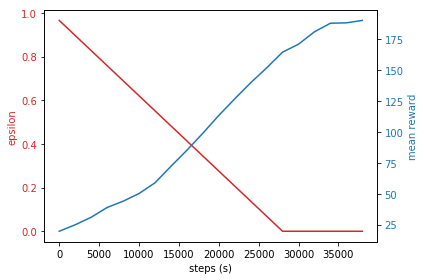

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# prep data(t, epsilon, reward_mean_last100) saved i results
final = []
for i in zip(*results):
    final.append(i)
#epsilon
data1=list(final[1])
reward_mean_last100
data2=list(final[2])
#t = T(=Number of total steps) /2000
t=[x for x in range(1,T+1,2000)]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('steps (s)')
ax1.set_ylabel('epsilon', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('mean reward', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Evaluation of Deep Reinforcement Learning Algorithms


As part of this notebook, we will evaluate our algorithm as done by the authors of DQN. The testing is very simple. Let the trained agent play the game $30$ times with an e-greedy policy with a fixed $\epsilon = 0.05$ and report the average high score (return).

- Load a pre-trained agent, potentially recreate a Q-Network graph.
- Run the agent for 30 episodes with an `evaluation_epsilon = 0.05`.
- Plot or print the results in a decent way.

In [20]:
import gym
import tensorflow as tf

tf.reset_default_graph()

evaluation_episodes = 30
evaluation_epsilon = 0.05
num_hidden=64
game = gym.make('CartPole-v0')
state = game.reset()
Q_network = DQNetwork('Q', num_inputs=4, num_hidden=num_hidden, num_outputs=2)
rewardsum = 0

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

with tf.Session() as sess:
    # Restore session
    saver.restore(sess, "./DPQmodel/modelDQL.ckpt")
    #play game for 'evaluation_episodes' episodes
    for t in range (1, evaluation_episodes + 1):
        game_over = False
        while not game_over:        
            at = choose_egreedy_action(sess, Q_network, [state], evaluation_epsilon)
            next_state, reward, game_over, info = game.step(at)
            state=next_state
            #add up reward of current episode
            rewardsum += reward
        #print("rewardsum after epsiode", t, ":", rewardsum)
        #reset game if game is over
        state = game.reset()
    game.close()
    #get average reward of all episodes
    print("Average reward after", evaluation_episodes, "episodes:", rewardsum/evaluation_episodes)

INFO:tensorflow:Restoring parameters from ./DPQmodel/modelDQL.ckpt
Average reward after 30 episodes: 189.56666666666666
